# Capstone Project - Bank Accessibility comparison for Illinois and New York, Greater Chicago and NYC (Week 2)

# Applied Data Science Capstone by IBM/Coursera


## Table of contents
* [Introduction: Business Problems](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Business Problems:

This projects intends to find bank accessability to people in Illinois and New York, then we will also try to compare Greater Chicago Aread and New York City. We will try to find answer to questions like:

1. How Illinois and Newyork are similar when compared in terms of banks density?
2. What are the top banks in terms of frequency in illinois and Newyork States?
3. If new bank want to open their branch or ATMs in either of State then which area should choose?
4. Who are the competitiors for the new aspirator bank or top bank operating in both States?
5. Which areas are having maximum banks and which banks dominates in those regions?
6. If an indivual want to open a bank account based on the bank nearest to him/her then what bank should he/she should be choosing?

### Data: To answer all of these questions we would need following data:

1. Name of all neighborhoods and their location in Illinois and New York : Illinois neighborhood names have been obtained by scrapping the website(https://www.geonames.org/postal-codes/US/IL/illinois.html) using beautiful soup and requests library.New York neighborhood names and their locations has been obtained from https://geo.nyu.edu/catalog/nyu_2451_34572.

2. Then using location data, I have used foursquare developer account to get list of nearest 10 banks within 500 metres range from the location if person tries to search banks. For that I have used search option and category id of banks as 4bf58dd8d48988d10a951735 

3. I would be mainly dealing with the frequency of banks in particular location or 10 search results for each location to asnwer all of the above three questions.


### Importing all libraries

In [1]:
import numpy as np
import geocoder
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Data Collection and Preparation for Illinois 

### Getting neighborhood areas name of Illinois by web scrapping using beautiful soup and requests

In [2]:
res = requests.get("https://www.geonames.org/postal-codes/US/IL/illinois.html")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[1] 
df = pd.read_html(str(table))
df=df[1].to_json(orient='records')
#print( tabulate(df[0], headers='keys', tablefmt='psql'))

In [7]:
df[0:500]

'[{"0":null,"1":"Place","2":"Code","3":"Country","4":"Admin1","5":"Admin2","6":"Admin3"},{"0":1.0,"1":"Chicago","2":"60601","3":"United States","4":"Illinois","5":"Cook","6":null},{"0":null,"1":"41.886\\/-87.618","2":null,"3":null,"4":null,"5":null,"6":null},{"0":2.0,"1":"Chicago","2":"60603","3":"United States","4":"Illinois","5":"Cook","6":null},{"0":null,"1":"41.88\\/-87.628","2":null,"3":null,"4":null,"5":null,"6":null},{"0":3.0,"1":"Chicago","2":"60605","3":"United States","4":"Illinois","5":"'

### loading data into json file

In [8]:
data=json.loads(df)

In [9]:
data[0:2]

[{'0': None,
  '1': 'Place',
  '2': 'Code',
  '3': 'Country',
  '4': 'Admin1',
  '5': 'Admin2',
  '6': 'Admin3'},
 {'0': 1.0,
  '1': 'Chicago',
  '2': '60601',
  '3': 'United States',
  '4': 'Illinois',
  '5': 'Cook',
  '6': None}]

### Converting data into dataframe

In [10]:
illinois_data=pd.DataFrame(data )
illinois_data.head(5)

,0,1,2,3,4,5,6
0,NaN,Place,Code,Country,Admin1,Admin2,Admin3
1,1.0,Chicago,60601,United States,Illinois,Cook,None
2,NaN,41.886/-87.618,None,None,None,None,None
3,2.0,Chicago,60603,United States,Illinois,Cook,None
4,NaN,41.88/-87.628,None,None,None,None,None


### Getting the number of data points

In [11]:
illinois_data.shape

(402, 7)

### Intermittent naming of columns to make final filtered data

In [12]:
illinois_data.columns=['A','B','C','D','E','F','G']

In [13]:
illinois_data.head()

,A,B,C,D,E,F,G
0,NaN,Place,Code,Country,Admin1,Admin2,Admin3
1,1.0,Chicago,60601,United States,Illinois,Cook,None
2,NaN,41.886/-87.618,None,None,None,None,None
3,2.0,Chicago,60603,United States,Illinois,Cook,None
4,NaN,41.88/-87.628,None,None,None,None,None


### We can see where A is NaN has name of areas data while its number has their geospatial data. We would try to filter these data and make own data frame and then merge it

In [14]:
Geo_data=illinois_data[illinois_data['A'].isna()]

In [15]:
Code_data=illinois_data[illinois_data['A'].notnull()]

In [16]:
print(Geo_data.shape,Code_data.shape)

(202, 7) (200, 7)


In [17]:
Geo_data.reset_index(inplace=True)
Geo_data.drop(['index'],axis=1,inplace=True)

C:\Users\deepa\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
location_column=pd.DataFrame(Geo_data['B'][1:201])

In [19]:
location_column.reset_index(inplace=True)
location_column.drop(['index'],inplace=True,axis=1)

In [20]:
location_column.head()

,B
0,41.886/-87.618
1,41.88/-87.628
2,41.871/-87.628
3,41.887/-87.639
4,41.872/-87.658


In [21]:
location_column.rename({'B':'location'},axis=1,inplace=True)
location_column.head()

,location
0,41.886/-87.618
1,41.88/-87.628
2,41.871/-87.628
3,41.887/-87.639
4,41.872/-87.658


### Converting location into string to able to separate it using string split function

In [22]:
location_column['location']=location_column['location'].astype(str)

In [23]:
C=[]
for i,j in location_column.iterrows():
    a=location_column.loc[i,'location'].split('/')
    C.append(a)
print(C[0:5])

[['41.886', '-87.618'], ['41.88', '-87.628'], ['41.871', '-87.628'], ['41.887', '-87.639'], ['41.872', '-87.658']]


In [24]:
loc=pd.DataFrame(C,columns=['latitude','longitude'])

In [25]:
loc.head()

,latitude,longitude
0,41.886,-87.618
1,41.88,-87.628
2,41.871,-87.628
3,41.887,-87.639
4,41.872,-87.658


### So, We got latitude and longitude of the all places

### Now we need to get the name and county of all the places

In [26]:
Code_data.head()

,A,B,C,D,E,F,G
1,1.0,Chicago,60601,United States,Illinois,Cook,None
3,2.0,Chicago,60603,United States,Illinois,Cook,None
5,3.0,Chicago,60605,United States,Illinois,Cook,None
7,4.0,Chicago,60606,United States,Illinois,Cook,None
9,5.0,Chicago,60607,United States,Illinois,Cook,None


In [27]:
Code_data=Code_data[['B','C','F']]

In [28]:
Code_data.reset_index(inplace=True)
Code_data.drop(['index'],axis=1,inplace=True)

In [29]:
Code_data.rename(columns={'B':'Place','C':'postcode','F':'county'},inplace=True)

In [30]:
Code_data.head()

,Place,postcode,county
0,Chicago,60601,Cook
1,Chicago,60603,Cook
2,Chicago,60605,Cook
3,Chicago,60606,Cook
4,Chicago,60607,Cook


In [31]:
Final_Data=pd.concat([Code_data,loc],axis=1)

In [32]:
Final_Data.head()

,Place,postcode,county,latitude,longitude
0,Chicago,60601,Cook,41.886,-87.618
1,Chicago,60603,Cook,41.88,-87.628
2,Chicago,60605,Cook,41.871,-87.628
3,Chicago,60606,Cook,41.887,-87.639
4,Chicago,60607,Cook,41.872,-87.658


In [36]:
Final_Data

,Place,postcode,county,latitude,longitude
0,Chicago,60601,Cook,41.886,-87.618
1,Chicago,60603,Cook,41.88,-87.628
2,Chicago,60605,Cook,41.871,-87.628
3,Chicago,60606,Cook,41.887,-87.639
4,Chicago,60607,Cook,41.872,-87.658
5,Chicago,60610,Cook,41.903,-87.634
6,Chicago,60611,Cook,41.897,-87.622
7,Chicago,60614,Cook,41.923,-87.648
8,Chicago,60657,Cook,41.94,-87.653
9,Alden,60001,McHenry,42.325,-88.452


In [37]:
Final_Data.shape

(200, 5)

### We can see we, have 200 places in illinois and we have their latitude and longitude as well

### Getting maps of Chicago

In [38]:
address = 'Chicago, Illinois, US'

geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of chicago are 41.8755616, -87.6244212.


In [39]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, county, place in zip(Final_Data['latitude'], Final_Data['longitude'], Final_Data['county'], Final_Data['Place']):
    label = '{}, {}'.format(place, a)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

Getting the Foursquare credentials

### Methodology:

Our aim for this project would be to search banks for all 200 places and 306 places in Illinois and NewYork respectively. For our search through Foursquare we have limited our distance to 500 metres or 0.310686 miles. I have assumed that the person wouldn't be willing to walk more than that distance. Also number of search has been limited to 10 for the same reason that the searcher would not look over results after 10 search.

Once we have all the top 10 search results for 200 places and 312 places in illinois and NewYork respectively. I would be detecting places where we are having maximum bank search results and places where no banks were found within 500m range to the search location. I would also try to find the bank which show up frequently in top 10 results for all the locations and thus provides provides maximum accessability to it's customers in all these locations. What are the top 5 banks having maximum branches in both the states and who are their competitors. Final what are the areas where new banks or existing banks should open their branches to get customers or provide access to people over those locations

### Analysis

### Foursquare Credentials for Search

In [40]:
# hidden 
#Foursquare id and password

CLIENT_ID = 'QAAXEG33DEMRTLWRYYW43Y5AD1NQNVBAHYLJOKH5X3BWAPUW' # Foursquare ID
CLIENT_SECRET = 'ZF0ULWL3DYUWTOHCP2BMARVZ2GUPAK535I0XPASB4EUO3O0B' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QAAXEG33DEMRTLWRYYW43Y5AD1NQNVBAHYLJOKH5X3BWAPUW
CLIENT_SECRET:ZF0ULWL3DYUWTOHCP2BMARVZ2GUPAK535I0XPASB4EUO3O0B


In [41]:
Final_Data.loc[0,'Place']

'Chicago'

### Getting list of banks for each location assuming an individual search for banks at location as given for each neighborhood name.

### We have few limitations:
    1. The search is done on foursquare 
    2. Search is done at particular location
    3. Same banks may operate with different names, I have considered names of banks as it is returned by the Foursquare

In [42]:
place_list=[]
radius=500
LIMIT=10
Bank_list=[]
for i,j in Final_Data.iterrows():
    neighborhood_latitude = Final_Data.loc[i, 'latitude'] # neighborhood latitude value
    neighborhood_longitude = Final_Data.loc[i, 'longitude'] # neighborhood longitude value

    neighborhood_name = Final_Data.loc[i, 'Place'] # neighborhood name
    place_list.append(neighborhood_name)
    # type your answer here
    ind_url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d10a951735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    result=requests.get(ind_url).json()
    Bank_list.extend([neighborhood_name,result])

In [43]:
#One can uncomment the result to see the JSON file output by FOURSQUARE
#result

### Making list of Banks and Places and storing them in E and F respectively. Creating error exception because there might be many places where Foursquare returns no banks names because they might not be in radius of 500m as we have set while doing search

In [44]:
E=[]
F=[]
for i in range(200):
    try: 
        q=Bank_list[0:400:2][i]
        p=pd.DataFrame(Bank_list[1:400:2][i]['response']['venues'])['name']
        E.append(p)
        F.append(q)
        
    except:
        pass

In [45]:
print(len(E),len(F))

81 81


In [46]:
pd9=pd.DataFrame(E)
pd10=pd9.T
pd10.columns=F

In [47]:
pd9.head()

,0,1,2,3,4,5,6,7,8,9
name,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank
name,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank
name,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage
name,Paypal / Venmo,Citibank,Ziegler,Wells Fargo,MB Financial Bank,Huntington Bank,U.S. Bank Branch,Bank of America,Chase Bank,Chase Bank
name,Citibank,Chase Bank,Fifth Third,National Republic Bank,Lakeside Bank,Washington Federal Savings,ABC Bank,NaN,NaN,NaN


In [48]:
pd10.head()

,Chicago,Chicago,Chicago,Chicago,Chicago,Chicago,Chicago,Chicago,Chicago,Arlington Heights,...,Channahon,Chicago Ridge,Coal City,Crestwood,Dolton,Flossmoor,Harvey,Homewood,Joliet,Lansing
0,Chase Bank,Capital One Café,Chase Bank,Paypal / Venmo,Citibank,Chase Bank,Chase Bank,Western Union,Bank of America,TCF Bank,...,Harris Bank,Archer Bank Chicago Ridge,Standard Bank,First Midwest Bank,Coinstar,Harris bank,Fifth Third Bank,Chase Bank,First midwest bank,Chase Bank
1,US Bank,Chase Bank,Byline Bank,Citibank,Chase Bank,Gold Coast Bank,Wintrust Bank Streeterville,MB Financial Bank,State Bank Of Countryside,Chase Bank,...,BMO ATM,NaN,Centrue Bank,Chase Bank,NaN,U.S. Bank Branch,NaN,First Midwest Bank,BankFinancial,First National Bank
2,Fifth Third Bank,Bank of America Building,New City Bank,Ziegler,Fifth Third,PNC Bank,CIBC Banking Center,U.S. Bank,First Switzerland Financial,Bank of America,...,NaN,NaN,NaN,Chase Bank,NaN,BMO Harris Bank,NaN,U.S. Bank Branch,NaN,First Savings Bank of Hegewisch
3,Citibank,BMO Harris Bank Headquarters,Harris Bank,Wells Fargo,National Republic Bank,TCF Bank,U.S. Bank Branch,Bank of America (ATM),MB Financial Bank,Village Bank &Trust,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PNC Mortgage,Federal Reserve Bank of Chicago,Coinstar,MB Financial Bank,Lakeside Bank,Coinstar,PNC Bank,North Community Bank,Northern Trust ATM,BMO Harris Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pd9.columns=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']

In [50]:
pd9.head(3)

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
name,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank
name,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank
name,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage


We can see the index of the search is name which we definitely don't want that. So, we are gonna reset the index

In [51]:
pd9.reset_index(inplace=True)
pd9.drop(['index'],axis=1,inplace=True)

In [52]:
pd9.head(3)

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank
1,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank
2,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage


We are going to add the place column so that we know what rows refers to what columns. F is the list which stores place name for 
which banks were found within 500m radius 

In [53]:
pd9['place']=F

In [54]:
pd9

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,place
0,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank,Chicago
1,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank,Chicago
2,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage,Chicago
3,Paypal / Venmo,Citibank,Ziegler,Wells Fargo,MB Financial Bank,Huntington Bank,U.S. Bank Branch,Bank of America,Chase Bank,Chase Bank,Chicago
4,Citibank,Chase Bank,Fifth Third,National Republic Bank,Lakeside Bank,Washington Federal Savings,ABC Bank,NaN,NaN,NaN,Chicago
5,Chase Bank,Gold Coast Bank,PNC Bank,TCF Bank,Coinstar,5/3 Bank,Chase Bank,Coinstar,North Community Bank,Bank of America,Chicago
6,Chase Bank,Wintrust Bank Streeterville,CIBC Banking Center,U.S. Bank Branch,PNC Bank,Bank of America,BMO Harris Bank,Chase Bank,North Community Bank,Chase Bank,Chicago
7,Western Union,MB Financial Bank,U.S. Bank,Bank of America (ATM),North Community Bank,Bridgeview Bank,PNC Mortgage,Coinstar,Citibank,BMO Harris Bank,Chicago
8,Bank of America,State Bank Of Countryside,First Switzerland Financial,MB Financial Bank,Northern Trust ATM,Harris Lakeview,Chase Bank,Bank of America,NaN,NaN,Chicago
9,TCF Bank,Chase Bank,Bank of America,Village Bank &Trust,BMO Harris Bank,Citibank,Coinstar,PNC Bank,NaN,NaN,Arlington Heights


In [55]:
#pd9.to_csv("C:/Users/deepa/Downloads/Illinois.csv")

In [56]:
pd9.shape

(81, 11)

### We can see that out of 200 places in illinois only 81 places has banks within 500m range. There might be a good opportunities for new banks to open their branch or atms at those locations

### Let'see the number of banks returned for Greater Chicago location

In [57]:
GreaterChicago=pd9[pd9['place']=='Chicago']

In [58]:
GreaterChicago['postcode']=Final_Data[Final_Data['Place']=='Chicago']['postcode']

C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
GreaterChicago.head()

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,place,postcode
0,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank,Chicago,60601
1,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank,Chicago,60603
2,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage,Chicago,60605
3,Paypal / Venmo,Citibank,Ziegler,Wells Fargo,MB Financial Bank,Huntington Bank,U.S. Bank Branch,Bank of America,Chase Bank,Chase Bank,Chicago,60606
4,Citibank,Chase Bank,Fifth Third,National Republic Bank,Lakeside Bank,Washington Federal Savings,ABC Bank,NaN,NaN,NaN,Chicago,60607


### Chase Bank is top search for 4 of the 8 locations and in top 5 in 6 out of the 8 locations in Chicago and in top 10 for 7 out of 8 locations. This means Chase really provides great service in terms of accessability to it's customers or ease of finding to potential customers. US Banks in top 5 locations for 4 out of 8 locations. Bank of America is in top 10 for 6 out of 8 locations. 

### Chase, US Bank and Bank of America are top 3 banks for Chicago area.

In [60]:
top_search=pd.concat([pd.DataFrame(pd9['place']),pd.DataFrame(pd9['1st'])],axis=1)
top_search.columns=['Place','top_search']

In [61]:
top_banks=top_search.groupby(by='top_search').count().sort_values(by='Place',ascending=False)

In [62]:
u=pd.DataFrame(top_banks['Place'][0:10]).reset_index()

In [63]:
u

,top_search,Place
0,Chase Bank,15
1,BMO Harris Bank,8
2,Fifth Third Bank & ATM,4
3,U.S. Bank Branch,3
4,TCF Bank,2
5,First Midwest Bank,2
6,Fifth Third Bank,2
7,Coinstar,2
8,Citibank,2
9,US Bank,2


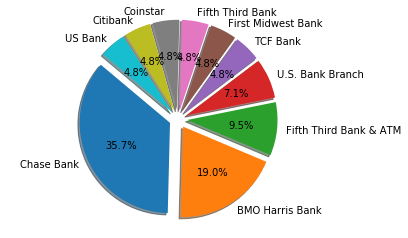

In [64]:
labels = list(u['top_search'])
sizes = list(u['Place'])
#colors = ['gold','blue','red','yellow','orange','purple']
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

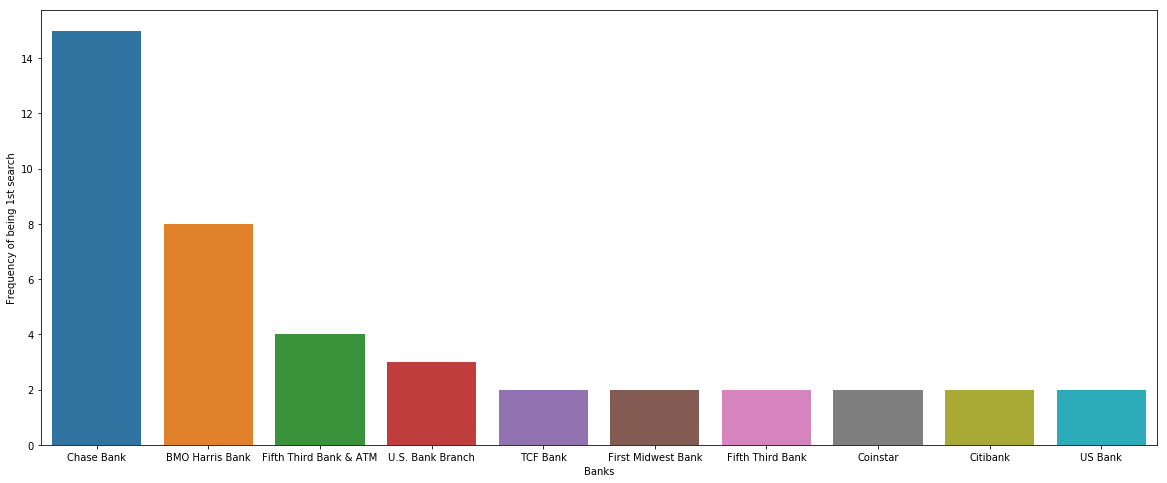

In [65]:
plt.subplots(figsize=(20,8))
sns.barplot(y='Place',x='top_search',data=u)
plt.xlabel('Banks')
plt.ylabel('Frequency of being 1st search')
plt.show

### Out of the 82 locations in Illinois that Foursquare returned banks 16 places has Chase Bank as top search or say nearest bank to the searchers followed by BMO Harris Bank at 8 locations and Fifth-Third at 4 locations, US Bank at 4 locations

### Let's see top 5 banks names for each 10 results. It's like we are getting 10 reuslts for each location. We are seeing top banks resulted in each 10 results. This result will tell us what are the banks which shows up frequently for each 10 result.

In [66]:
pd9.columns

Index(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th',
       'place'],
      dtype='object')

In [67]:
pd9.head(3)

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,place
0,Chase Bank,US Bank,Fifth Third Bank,Citibank,PNC Mortgage,PNC Mortgage,U.S. Bank Branch,PNC Bank,PNC Bank,Chase Bank,Chicago
1,Capital One Café,Chase Bank,Bank of America Building,BMO Harris Bank Headquarters,Federal Reserve Bank of Chicago,Northern Trust,Fifth Third Bank & ATM,Chase Bank,Northern Trust,Chase Bank,Chicago
2,Chase Bank,Byline Bank,New City Bank,Harris Bank,Coinstar,Fifth Third Bank & ATM,First American Bank,TCF Bank,BMO Harris Bank,PNC Mortgage,Chicago


In [68]:
pd9.groupby(by='place').count().sum()

1st     81
2nd     54
3rd     42
4th     25
5th     21
6th     16
7th     14
8th     10
9th      7
10th     7
dtype: int64

In [69]:
df_place=pd9.groupby(by='place').count()

In [70]:
bankcounts=pd.DataFrame(df_place.sum(axis=1).sort_values(ascending=False))

In [71]:
bankcounts.reset_index(inplace=True)

In [72]:
bankcounts.columns=['Place','count']

In [73]:
final_count_data=pd.merge(Final_Data,bankcounts,on='Place')

In [118]:
bank_illinois=final_count_data.drop(['postcode','county','latitude','longitude'],axis=1).drop_duplicates().sort_values(by='count',ascending=False)

In [119]:
bank_illinois

,Place,count,cluster
0,Chicago,85,1
54,Elgin,13,2
9,Arlington Heights,11,2
77,Evanston,11,2
59,Geneva,8,3
83,Oak Park,8,3
74,West Chicago,8,3
18,Des Plaines,7,3
39,Park Ridge,7,3
61,Glen Ellyn,6,3


In [120]:
# set number of clusters
final_count_data["cluster"]=None
for index, row in final_count_data.iterrows():
    if row[5]>=50:
        final_count_data['cluster'].iloc[index]=1
    elif row[5]>=10:
        final_count_data['cluster'].iloc[index]=2
    elif row[5]>=5:
        final_count_data['cluster'].iloc[index]=3
    elif row[5]>=2:
        final_count_data['cluster'].iloc[index]=4
    elif row[5]>=0:
        final_count_data['cluster'].iloc[index]=5

C:\Users\deepa\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [121]:
final_count_data.groupby('cluster').count()

,Place,postcode,county,latitude,longitude,count
cluster,,,,,,
1,9,9,9,9,9,9
2,12,12,12,12,12,12
3,21,21,21,21,21,21
4,39,39,39,39,39,39
5,22,22,22,22,22,22


In [122]:
final_count_data.columns

Index(['Place', 'postcode', 'county', 'latitude', 'longitude', 'count',
       'cluster'],
      dtype='object')

### There 9 out of 200 locations in illinois where total number of banks within 500m range of the person is more than 50 which is mainly all Greater Chicago area. 39 low Density area where number of banks search is less than 5 but greater than 2. 22 very low density area while 97 locations gave no search result for banks within 500m  of the location

In [123]:
address = 'Chicago, Illinois, US'

geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of chicago are 41.8755616, -87.6244212.


In [124]:
# create map
kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_count_data['latitude'], final_count_data['longitude'], final_count_data['Place'], final_count_data['cluster']):
    label = folium.Popup(str(poi) + ' cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [125]:
bank_results=[]
for i in pd9[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']].columns:
    top_search1=pd.concat([pd.DataFrame(pd9['place']),pd.DataFrame(pd9[i])],axis=1)
    top_search1.columns=['place','top']
    t=top_search1.groupby(by='top').count().sort_values(by='place',ascending=False)['place'][0:5]
    bank_results.append(t)
    

In [126]:
# We already saw Chase is 1st result in 15/81 locations followed by BMO Harris and US Bank Branch
bank_results[0]

top
Chase Bank                15
BMO Harris Bank            8
Fifth Third Bank & ATM     4
U.S. Bank Branch           3
TCF Bank                   2
Name: place, dtype: int64

In [127]:
#Chase is in 2nd search for 10/81 locations followed by US Bank at 5 and Coinstar at 5 locations
bank_results[1]

top
Chase Bank          10
U.S. Bank Branch     5
Coinstar             5
Byline Bank          2
Citibank             2
Name: place, dtype: int64

In [128]:
bank_results[2]

top
Chase Bank          4
U.S. Bank Branch    4
Coinstar            4
PNC Bank            2
5/3 Bank            1
Name: place, dtype: int64

In [129]:
bank_results[3]

top
Bank of America             2
U.S. Bank                   2
American Enterprise Bank    1
Inland Bank                 1
Village Bank &Trust         1
Name: place, dtype: int64

In [130]:
bank_results[4]

top
BMO Harris Bank                    3
Coinstar                           2
MB Financial Bank                  2
Chase Bank                         1
Federal Reserve Bank of Chicago    1
Name: place, dtype: int64

In [131]:
bank_results[5]

top
PNC Bank           2
TCF Bank           2
5/3 Bank           1
Bank of America    1
Bridgeview Bank    1
Name: place, dtype: int64

In [132]:
bank_results[6]

top
BMO Harris Bank             2
Chase Bank                  2
U.S. Bank Branch            2
ABC Bank                    1
Bank of America Aircraft    1
Name: place, dtype: int64

In [133]:
bank_results[7]

top
Bank of America    2
Chase Bank         2
Coinstar           2
PNC Bank           2
TCF Bank           1
Name: place, dtype: int64

In [134]:
bank_results[8]

top
North Community Bank    2
BMO Harris Bank         1
Chase Bank              1
Citibank                1
Northern Trust          1
Name: place, dtype: int64

In [135]:
bank_results[9]

top
Chase Bank         4
BMO Harris Bank    1
Bank of America    1
PNC Mortgage       1
Name: place, dtype: int64

In [136]:
chicagodata=pd.DataFrame(bank_results).reset_index().drop(['index'],axis=1)

In [137]:
chicagodata.head()

,Chase Bank,BMO Harris Bank,Fifth Third Bank & ATM,U.S. Bank Branch,TCF Bank,Coinstar,Byline Bank,Citibank,PNC Bank,5/3 Bank,...,Inland Bank,Village Bank &Trust,MB Financial Bank,Federal Reserve Bank of Chicago,Bridgeview Bank,ABC Bank,Bank of America Aircraft,North Community Bank,Northern Trust,PNC Mortgage
0,15.0,8.0,4.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,5.0,NaN,5.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,4.0,NaN,4.0,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
chicagodata['Chase Bank'].sum()

39.0

In [139]:
chicagodata['BMO Harris Bank'].sum()

15.0

In [140]:
chicagodata['U.S. Bank Branch'].sum()

14.0

In [141]:
chicagodata['Fifth Third Bank & ATM'].sum()

4.0

In [142]:
chicagodata['Coinstar'].sum()

13.0

In [143]:
chicagodata['Bank of America'].sum()

6.0

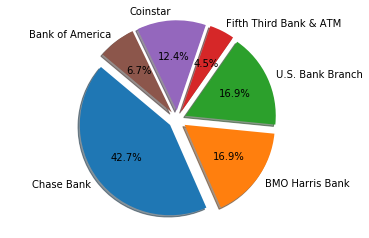

In [144]:
labels = ['Chase Bank','BMO Harris Bank','U.S. Bank Branch','Fifth Third Bank & ATM','Coinstar','Bank of America']
sizes = [38,15,15,4,11,6]
#colors = ['gold','blue','red','yellow','orange','purple']
explode = (0.1,0.1,0.1,0.1,0.1,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

### Seeing the result Chase is in top 5 search for 39/81 locations. That's a great accessibility. US Bank is in top 5 serach for 18/81 of locations. BMO Harris is in 15/81 locations in top 5 search, Coinstar in 14/81 locations So, Chase, US BANK, BMO Harris and Bank of America are top 4 banks of Illinois in terms of accessibilty within 500m range to person since, Coinstar is not really a bank

# Newyork

### Getting Data. This data has been used by IBM for geospatial locations of Newyork so, I am using same data sets

In [145]:
Final_Data1=pd.read_excel("C:/Users/deepa/Downloads/data.xlsx")

Naming columns

In [146]:
Final_Data1.columns=['County','Place','latitude','longitude']

In [147]:
Final_Data1.head(5)

,County,Place,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [148]:
Final_Data1.shape

(306, 4)

We have 306 areas in Newyork compared to only 200 in Illinois

In [149]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [150]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, place, county in zip(Final_Data1['latitude'], Final_Data1['longitude'], Final_Data1['Place'], Final_Data1['County']):
    label = '{}, {}'.format(place, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [151]:
Final_Data1.loc[0,'Place']

'Wakefield'

### Getting List of Banks for each locations of Newyork

In [152]:
County_list=[]
radius=500
LIMIT=10
Bank_list1=[]
for i,j in Final_Data1.iterrows():
    neighborhood_latitude = Final_Data1.loc[i, 'latitude'] # neighborhood latitude value
    neighborhood_longitude = Final_Data1.loc[i, 'longitude'] # neighborhood longitude value

    neighborhood_name = Final_Data1.loc[i, 'Place'] # neighborhood name
    neighborhood_county=Final_Data1.loc[i, 'County']
    County_list.append(neighborhood_county)
    # type your answer here
    ind_url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d10a951735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    result1=requests.get(ind_url).json()
    Bank_list1.extend([neighborhood_name,result1])

In [153]:
#Please uncomment this to see the result by foursquare in JSON file
#result1

In [154]:
Bank_list1[0:2]

['Wakefield',
 {'meta': {'code': 200, 'requestId': '5d7714a26e465000343b2b3c'},
  'response': {'venues': [{'id': '4d99c56e2bd6f04de9758550',
     'name': 'Citibank',
     'location': {'address': '3955 Baychester Ave',
      'lat': 40.89416116355705,
      'lng': -73.84582476612417,
      'labeledLatLngs': [{'label': 'display',
        'lat': 40.89416116355705,
        'lng': -73.84582476612417}],
      'distance': 130,
      'postalCode': '10466',
      'cc': 'US',
      'city': 'Bronx',
      'state': 'NY',
      'country': 'United States',
      'formattedAddress': ['3955 Baychester Ave',
       'Bronx, NY 10466',
       'United States']},
     'categories': [{'id': '4bf58dd8d48988d10a951735',
       'name': 'Bank',
       'pluralName': 'Banks',
       'shortName': 'Bank',
       'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/financial_',
        'suffix': '.png'},
       'primary': True}],
     'referralId': 'v-1568085154',
     'hasPerk': False}],
   'confident': 

In [163]:
E1=[]
F1=[]
for i in range(200):
    try: 
        q=Bank_list1[0:612:2][i]
        p=pd.DataFrame(Bank_list1[1:612:2][i]['response']['venues'])['name']
        E1.append(p)
        F1.append(q)
        
    except:
        pass
    

In [164]:
E1[0:3]

[0    Citibank
 Name: name, dtype: object, 0    Amalgamated Bank - Bartow Mall
 1                              HSBC
 2             Emigrant Savings Bank
 Name: name, dtype: object, 0          Chase Bank
 1                HSBC
 2        HSBC W235 St
 3    Capital One Bank
 4     Bank of America
 5          Apple Bank
 6        Country Bank
 Name: name, dtype: object]

In [165]:
pd91=pd.DataFrame(E1)
pd101=pd91.T
pd101.columns=F1

In [166]:
pd91.head()

,0,1,2,3,4,5,6,7,8,9
name,Citibank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,Amalgamated Bank - Bartow Mall,HSBC,Emigrant Savings Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,Chase Bank,HSBC,HSBC W235 St,Capital One Bank,Bank of America,Apple Bank,Country Bank,NaN,NaN,NaN
name,Citibank,Chase Bank,Bank of America,Coinstar,Ponce De Leon Federal Bank,NaN,NaN,NaN,NaN,NaN
name,Bank Of America ATM,Chase Bank,Chase Bank,Ponce De Leon Federal Bank,Chase Bank,Wells Fargo,TD Bank,NaN,NaN,NaN


In [167]:
pd91.columns=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']

In [168]:
pd91.reset_index(inplace=True)
pd91.drop(['index'],axis=1,inplace=True)
pd91.head(3)

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Citibank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amalgamated Bank - Bartow Mall,HSBC,Emigrant Savings Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chase Bank,HSBC,HSBC W235 St,Capital One Bank,Bank of America,Apple Bank,Country Bank,NaN,NaN,NaN


In [169]:
pd91['Place']=F1

In [170]:
#pd91.to_csv("C:/Users/deepa/Downloads/Newyork.csv")

In [191]:
pd91

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,Place
0,Citibank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wakefield
1,Amalgamated Bank - Bartow Mall,HSBC,Emigrant Savings Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Co-op City
2,Chase Bank,HSBC,HSBC W235 St,Capital One Bank,Bank of America,Apple Bank,Country Bank,NaN,NaN,NaN,Riverdale
3,Citibank,Chase Bank,Bank of America,Coinstar,Ponce De Leon Federal Bank,NaN,NaN,NaN,NaN,NaN,Kingsbridge
4,Bank Of America ATM,Chase Bank,Chase Bank,Ponce De Leon Federal Bank,Chase Bank,Wells Fargo,TD Bank,NaN,NaN,NaN,Marble Hill
5,Bank of America,Chase Bank,Hudson Valley Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Woodlawn
6,Chase Bank,MCU ATM,Capital One Bank,Ridgewood bank Jerome Avenue,citibank,Bank of America,Citibank,Chase Bank,NaN,NaN,Norwood
7,HSBC Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Williamsbridge
8,Chase Bank,Emigrant Savings Bank,Ridgewood Savings Bank,ATN Financial Services,NaN,NaN,NaN,NaN,NaN,NaN,Baychester
9,Capital One Bank,"United Northern Mortgage Bankers, LTD.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pelham Parkway


In [171]:
pd91.shape

(172, 11)

In [172]:
df_place1=pd91.groupby(by='Place').count()

In [173]:
nybankcounts=pd.DataFrame(df_place1.sum(axis=1).sort_values(ascending=False))

In [174]:
nybankcounts.reset_index(inplace=True)

In [175]:
nybankcounts.columns=['Place','count']

In [176]:
final_count_data1=pd.merge(Final_Data1,nybankcounts,on='Place')

In [177]:
final_count_data1.groupby('count').count()

,County,Place,latitude,longitude
count,,,,
1,30,30,30,30
2,18,18,18,18
3,22,22,22,22
4,14,14,14,14
5,18,18,18,18
6,8,8,8,8
7,9,9,9,9
8,10,10,10,10
9,17,17,17,17


In [178]:
final_count_data1.shape

(175, 5)

In [179]:
# set number of clusters
final_count_data1["cluster"]=None
for index, row in final_count_data1.iterrows():
    if row[4]>=12:
        final_count_data1['cluster'].iloc[index]=1
    elif row[4]>=10:
        final_count_data1['cluster'].iloc[index]=2
    elif row[4]>=5:
        final_count_data1['cluster'].iloc[index]=3
    elif row[4]>=2:
        final_count_data1['cluster'].iloc[index]=4
    elif row[4]>=0:
        final_count_data1['cluster'].iloc[index]=5

C:\Users\deepa\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [180]:
final_count_data1.groupby('cluster').count()

,County,Place,latitude,longitude,count
cluster,,,,,
1,2,2,2,2,2
2,27,27,27,27,27
3,62,62,62,62,62
4,54,54,54,54,54
5,30,30,30,30,30


In [192]:
final_count_data1.sort_values(by='count',ascending=False)

,County,Place,latitude,longitude,count,cluster
101,Manhattan,Murray Hill,40.748303,-73.978332,15,1
102,Queens,Murray Hill,40.764126,-73.812763,15,1
87,Manhattan,Washington Heights,40.851903,-73.936900,10,2
105,Manhattan,Greenwich Village,40.726933,-73.999914,10,2
119,Queens,Jackson Heights,40.751981,-73.882821,10,2
117,Queens,Astoria,40.768509,-73.915654,10,2
116,Manhattan,Financial District,40.707107,-74.010665,10,2
115,Manhattan,Battery Park City,40.711932,-74.016869,10,2
114,Manhattan,Gramercy,40.737210,-73.981376,10,2
40,Brooklyn,Bay Ridge,40.625801,-74.030621,10,2


In [193]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [194]:
# create map
Kclusters=5
map_clusters_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_count_data1['latitude'], final_count_data1['longitude'], final_count_data1['Place'], final_count_data1['cluster']):
    label = folium.Popup(str(poi) + ' cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

### We can see that we got bank results for 172 out of 306 locations which is better than Illinois's 81/200 locations

In [195]:
top_search=pd.concat([pd.DataFrame(pd91['Place']),pd.DataFrame(pd91['1st'])],axis=1)
top_search.columns=['Place','top']

In [196]:
top_banks=top_search.groupby(by='top').count().sort_values(by='Place',ascending=False)

In [197]:
u=pd.DataFrame(top_banks['Place'][0:10]).reset_index()

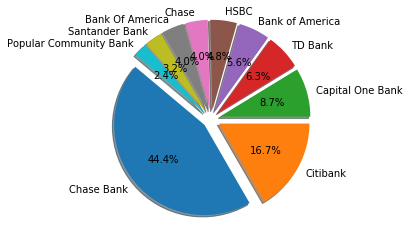

In [198]:
labels = list(u['top'])
sizes = list(u['Place'])
#colors = ['gold','blue','red','yellow','orange','purple']
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

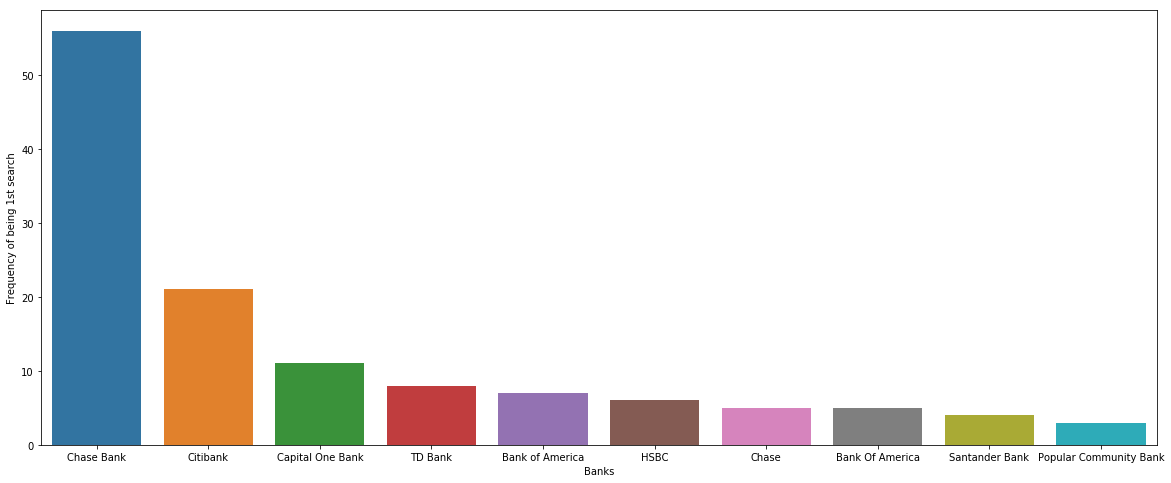

In [199]:
plt.subplots(figsize=(20,8))
sns.barplot(y='Place',x='top',data=u)
plt.xlabel('Banks')
plt.ylabel('Frequency of being 1st search')
plt.show

### We can see 60 out of 172 locations, Chase is at the top

In [200]:
pd91.columns

Index(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th',
       'Place'],
      dtype='object')

### This will get top 5 bank names for all 10 searches and sort it according to frequency of results out of all the locations 

In [201]:
A=[]
for i in pd91[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']].columns:
    top_search1=pd.concat([pd.DataFrame(pd91['Place']),pd.DataFrame(pd91[i])],axis=1)
    top_search1.columns=['Place','top']
    t=top_search1.groupby(by='top').count().sort_values(by='Place',ascending=False)['Place'][0:5]
    A.append(t)

In [202]:
A[0]

top
Chase Bank          56
Citibank            21
Capital One Bank    11
TD Bank              8
Bank of America      7
Name: Place, dtype: int64

In [203]:
A[1]

top
Chase Bank          28
Coinstar            13
Citibank             9
Capital One Bank     9
Bank of America      7
Name: Place, dtype: int64

In [204]:
A[2]

top
Chase Bank          22
Citibank            13
Bank of America      9
TD Bank              7
Capital One Bank     6
Name: Place, dtype: int64

In [205]:
A[3]

top
Chase Bank          18
Capital One Bank     6
Citibank             6
TD Bank              6
Coinstar             4
Name: Place, dtype: int64

In [206]:
A[4]

top
Chase Bank         11
TD Bank             7
Citibank            5
Bank of America     5
Santander Bank      3
Name: Place, dtype: int64

In [207]:
A[5]

top
Chase Bank                    11
Citibank                       8
Capital One Bank               5
Williamsburgh Savings Bank     3
Ridgewood Savings Bank         3
Name: Place, dtype: int64

In [208]:
A[6]

top
TD Bank                   12
Capital One Bank           8
Chase Bank                 6
Citibank                   5
Popular Community Bank     3
Name: Place, dtype: int64

In [209]:
A[7]

top
Bank of America    8
Chase Bank         7
TD Bank            5
Citibank           4
HSBC               4
Name: Place, dtype: int64

In [210]:
A[8]

top
Chase Bank         8
Bank of America    6
TD Bank            5
HSBC               3
PNC Bank           2
Name: Place, dtype: int64

In [211]:
A[9]

top
Chase Bank          7
Capital One Bank    4
TD Bank             3
Bank Of America     2
PNC Bank            2
Name: Place, dtype: int64

### We can see that Chase Bank dominates almost all the bank with maximum number of showup for all the 10 results for each 172 locations 

### Chase Bank dominates almost both in Chicago and Newyork but certainly it has more presence in Newyork

In [212]:
nydata=pd.DataFrame(A).reset_index().drop(['index'],axis=1)

In [213]:
nydata['Chase Bank'].sum()

174.0

In [214]:
nydata['Citibank'].sum()

71.0

In [215]:
nydata['Capital One Bank'].sum()

49.0

In [216]:
nydata['TD Bank'].sum()

53.0

In [217]:
nydata['Bank of America'].sum()

42.0

In [218]:
nydata['Coinstar'].sum()

17.0

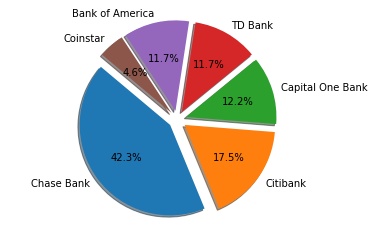

In [219]:
labels = ['Chase Bank','Citibank','Capital One Bank','TD Bank','Bank of America','Coinstar']
sizes = [174,72,50,48,48,19]
#colors = ['gold','blue','red','yellow','orange','purple']
explode = (0.1,0.1,0.1,0.1,0.1,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

### Top 5 accessible banks in Newyork are Chase Bank, Citibank, TD Bank, Capital One Bank and Bank of America

### Results and Discussion

1. Our Analysis and comparison on Bank search and clustering of region on the basis of banks between New York and Chicago gave some iteresting takeways and solutions to the business questions we asked:

### We had these business problems?

### How Illinois and Newyork are similar compared to banks density?

Out of 200 locations in Illinois only 81 locations has bank within 500m range of the location where search was carried out while 
New York has 172 locations which has banks within 500m range out of total 306 locations 

Chase Bank dominates in both illinois and New York City. In Illinois Chase bank was closest in 16 out of 81 locations where as in New York it was 62 out of 172 locations

In total, Chase bank showed up in top 10 closest bank in 39 out of 81 locations whereas in NewYork Chase was in top 10 closest bank in all of 172 loctions

In terms of all locations Greater Chicago area has most number of banks and in New York, New York City and Murray hill has most number of Banks

### What are the top banks in terms of frequenncy in illinois and Newyork States?

In Illinois, Chase, BMO Harris, US Bank, Fifth third Bank and Bank of America were top 5 banks in term of accessability or maximum branches closest to the search location 

In New York, Chase, Citi Bank, Capital One Bank, TD Bank and Bank of Ameria were top 5 banks most closest to all the search locations 

### If new bank want to open their branch or ATMs in either of State then which area should choose ?

Only 81 out of 200 locations had bank in 500m range of search locations so, it would be good idea to open bank braches in remaining 119 locations of regions having very less number of Banks. Similarly New York has banks only in 172 out of 306 locations and certainly denser than Chicago. It would be good to open banks in remaining 134 locations or region of low banks density


### Who are the competitiors for the new aspirator bank or top bank operating in both States ?

In Illinois, Chase, BMO Harris, US Bank, Fifth third Bank and Bank of America were top 5 banks in term of accessability or maximum branches closest to the search location and definitely tough competitors for any new old bank or each other.

In New York, Chase, Citi Bank, Capital One Bank, TD Bank and Bank of Ameria were top 5 banks most closest to all the search locations and are tough competitors to others as well as each others

### Which areas are having maximum banks and which banks dominates in those regions 

In terms of all locations Greater Chicago area has most number of banks and in New York, New York City and Murray hill has most number of Banks

Chase dominates in both the regions

Chase Bank is top search for 4 of the 8 locations and in top 5 in 6 out of the 8 locations in Chicago and in top 10 for 7 out of 8 locations. This means Chase really provides great service in terms of accessability to it's customers or ease of finding to potential customers. US Banks in top 5 locations for 4 out of 8 locations. Bank of America is in top 10 for 6 out of 8 locations. Chase, US Bank and Bank of America are top 3 banks for Chicago area.

### If an indivual want to open a bank account based on the bank nearest to him/her then what bank should he/she should be choosing?

If a person is in Illinois these are the best options: Chase, BMO Harris, US Bank, Fifth third Bank and Bank of America

If a person is in New York, Chase, Citi Bank, Capital One Bank, TD Bank and Bank of America are the best options

### Conclusion

This projects was done to find the top banks in Chicago and New York and clearly Chase is top in both the locations. But there are some limitations of the project. First, the search in all the regions are done at specific locations and there are some possibilties that the banks numbers and region would vary if we change the locations. We also need to assume that result give by Foursquare is true.

If new Bank want to open a branch in Illinois or NewYork, we need to study the population and bank number per people or per miles square before taking business decision however, the study is beyond the scope of this project.

A person might not choose a bank in terms of accessibility only. Other factors like interest rate on savings, service and staffs are also important factors.